In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

In [3]:
# LEER MODELO 
nuevo_model = keras.models.load_model(r'C:\Users\jchinome\OneDrive - Grupo Bancolombia\Auditoria\Automatizacion Querys\Capcha\Modelo\path_to_my_model2.h5',custom_objects={'CTCLayer': CTCLayer})

In [4]:
# DEFINIR LOS CARACTERES ( SON LOS MISMOS CARACTERES QUE LOS DEL ENTRENAMIENTO Y EN EL MISMO ORDEN)
characters = ['2', '3', '4', '5', '6', '7', '8', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'm', 'n', 'p', 'r', 'w', 'x', 'y']

In [20]:
# MAPEAR CARACTERES:

# Mapear caracteres a números enteros
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapear enteros a los caracteres originales
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [21]:
def encode_single_sample2(img):
    # Se define las dimenciones de la imagen de entreda 
    img_width = 204
    img_height = 53
    # 2. Convertimos la imagen a escala de grices 
    img = np.reshape(img,(53, 204,1))
    # 3. Convertimos a float32 en un rangi de [0,1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize para mantener el ancho y alto deseado.
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transponemos la imagen 
    img = tf.transpose(img, perm=[1, 0, 2])
    return {"image": img}

In [22]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :5] # 5 Longitud del captcha a predecir.
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [23]:
prediction_model = keras.models.Model(nuevo_model.get_layer(name="image").input, nuevo_model.get_layer(name="dense2").output)

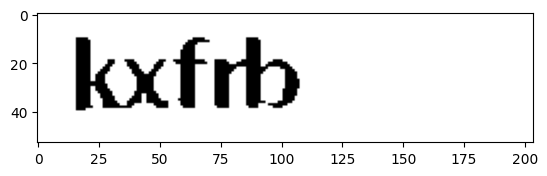

In [28]:
# LEEMOS IMAGEN DE PREDICCION DISTINTO A LOS DE ENTRENAMIENTO Y VALIDACION :

data_dir_pred = Path("C:/Users/jchinome/Documents/ImagenesPrueba/prediccion/")
images_predict = sorted(list(map(str, list(data_dir_pred.glob("*.png")))))

imageno=plt.imread(images_predict[115])
plt.imshow(imageno,cmap="gray")

In [29]:
# TRANSFORMACION DE LA IMAGEN EN LA ENTRADA DE MODELO.
pred_dataset=encode_single_sample2(imageno)
batch_imagenes = pred_dataset["image"]
size_img=1
batch_imagenes = np.reshape(batch_imagenes,(size_img,204, 53, 1))


# MONTAMOS LA IMAGEN RESULTANTE EN EL MODELO DE PREDICCION.
prediccion = prediction_model.predict(batch_imagenes)
pred_texts_vv = decode_batch_predictions(prediccion)

1/1 [==============================] - 0s 49ms/step


In [30]:
print(pred_texts_vv)

['kxfrb']
